In [1]:
#Spatially explicit metapopulation version of the model

using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots


function multipop(npops::Int64,mmat::Matrix{Float64},n::Int64,r::Vector{Float64},
                    K::Vector{Float64},pa::Float64,SST::Matrix{Float64},tsteps::Int64)

    
    #no. of loci
    n=114
    pheno= collect(1:(2*n+1)) ./ (2*n+1)
    nt=length(pheno)
    
    #Precalculate the probabilities of getting an offspring with trait k when the gametes with 'trait 
    #value' i an j are combined
    
    G=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                m=collect(0:min(j,k,i+j-k))
                G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
    end

    for k in 0:n
        G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
        for i1 in 0:n
            G[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
             ind_haplR[1+i,1+k] = G[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
         R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                             ind_haplR[1+j,1+q .- (0:q)])
    end
        
    N=rand(Uniform(0,1.0),npops,nt)
    Ng0= N ./ sum(eachcol(N))
    Np0= 950 .* Ng0 
    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)

    #Set up optimal traits value change with time using SST data
    #Initial value is the population mean (this assumes that the local populations are 
    #alrady adapted to the local temperature).
        
    topt0= [sum(pheno .* Np[x,:])/sum(Np[x,:]) for x in 1:size(Np)[1]]

    topts=topt0 .+ (1.2 .* SST')
        
    #precalculate selection pressure on phenotypes across time steps
    probsurv=zeros(Float64, tsteps, npops, nt)
        
    [probsurv[x,y,:]=exp.(-((topts[y,x] .-pheno) .^2) ./ 0.16) for x in 1:tsteps, y in 1:npops ]
     
    #Store results
    res=zeros(Float64,tsteps+1,npops,nt)

    res[1,:,:]=Np0
        

    for t in 1:tsteps
            
        if sum(floor.(Np))<1
                break
        
        else

            #Selection event
            
            Np=Np .* (probsurv[t,:,:])

            #Reproduction event

            if(pa<1)

                newgen=zeros(Float64,npops,nt)

                for i in 1:size(Ngen)[1]
                    
                    Ngen[i,:]=Np[i,:]/sum(Np[i,:])

                    probs=Ngen[i,:]*(Ngen[i,:]')

                    for j in 1:size(Ngen)[2]

                        newgen[i,j]=sum(probs.*R[:,:,i])
                    end

                    Np[i,:]=((pa*sum(Np[i,:])) .* Ngen[i,:]) + (((1-pa)*sum(Np[i,:])) .* newgen[i,:])  

                end
            end

            #Settlement

            for i in 1:size(Np)[1]
                    
                #Logistic growth to simulate crowding effect during settlement
                Ngen[i,:]=Np[i,:]/sum(Np[i,:])
                                                        
                Np[i,:]=(sum(Np[i,:])+ (r[i]*sum(Np[i,:])*(1-(sum(Np[i,:])/K[i])))) .* Ngen[i,:]

            end

            #Migration
            #add fraction of populations to each other (uniformly across all phenotypes) according to
            #the migration matrix mmat
            for i in 1:size(Np)[1], j in 1:size(Np)[1]

                Np[i,:] += mmat[i,j] .* Np[j,:]
                
            end
            
            Np[Np .<1 ] .= 0
            
            res[t+1,:,:]=Np
            
            
  
        end
    end
    
    return res
        
end
        



multipop (generic function with 1 method)

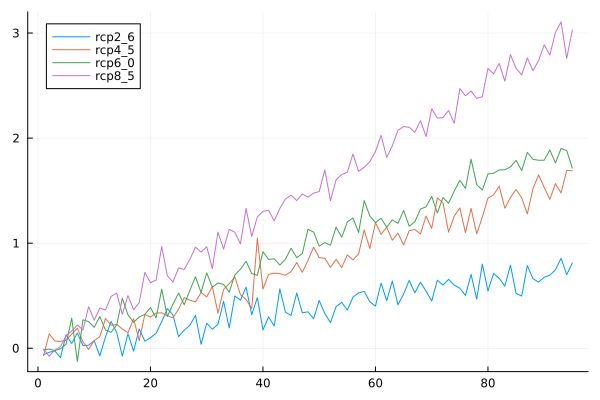

In [2]:
#Model parameters/Function inputs

#no. of loci
n=114
pheno= collect(1:(2*n+1)) ./ (2*n+1)
nt=length(pheno)

#No. subpopulations
npops=2

#Growth rate
r=repeat([1.38],npops)

#Carrying capacity
K=repeat([1000.0],npops)

#Proportion of asexually reproducing individuals
pa=0.6

#Migration matrix NpopsXNpops: Indicates the proportion of the population migrating
#from pop i to pop j
mmat=ones(Float64,npops,npops)
#The matrix can be customised with empirical data
mmat=[0 0.1
      0  0 ]

#SST data
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]
       
[ SSTs[:,i] += rand(Normal(0,0.1),size(SSTs)[1]) for i in 1:(size(SSTs)[2]) ]
    
plot(SSTs[:,1], label=names(SSTs)[1])
plot!(SSTs[:,2], label=names(SSTs)[2])
plot!(SSTs[:,3], label=names(SSTs)[3])
plot!(SSTs[:,4], label=names(SSTs)[4])


In [11]:
#Run the function for the scenario for the mainland-island dynamic:
#One bigger population (bigger K) which ONLY sends individuals (no immigration) 
#to the smaller island (smaller K).

#Perhaps different environmental trends for different subpopulations??

# Params to vary: pa, mmat, (possibly SST)

SST=Matrix(SSTs[:,[2,1]])

95×2 Matrix{Float64}:
 -0.0697875  -0.0618086
  0.136506   -0.0387872
  0.0683644  -0.0256955
  0.0648178  -0.0887577
  0.0755247   0.12763
  0.135123    0.0453755
  0.190691    0.144654
  0.0606038   0.0261084
 -0.0105228   0.0281023
  0.0724445   0.0716515
  0.1104     -0.0726866
  0.282079    0.106294
  0.219281    0.254804
  ⋮          
  1.43559     0.790908
  1.51105     0.521249
  1.43212     0.49708
  1.27767     0.787086
  1.51854     0.662064
  1.64945     0.629437
  1.53095     0.675853
  1.41698     0.69493
  1.56649     0.746689
  1.47746     0.856178
  1.69225     0.700414
  1.68962     0.811608

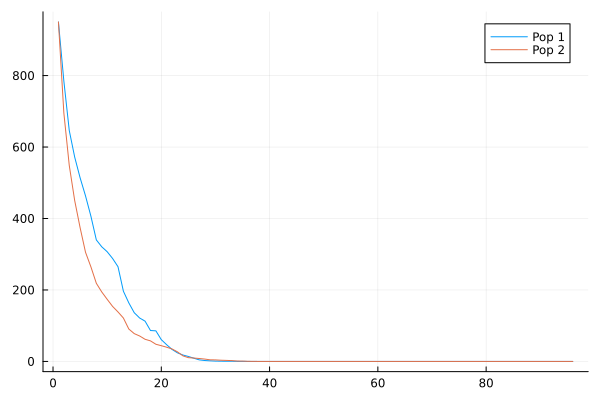

In [12]:
resdat=multipop(npops,mmat,n,r,K,pa,SST,tsteps)

resdat1=DataFrame()

for i in 1:size(resdat)[1]
    
        append!(resdat1,DataFrame(time=i,N1=sum(resdat[i,1,:]), N2=sum(resdat[i,2,:])))
    
end

plot(resdat1.time,resdat1.N1,label="Pop 1")
plot!(resdat1.time,resdat1.N2,label="Pop 2")

In [14]:
 N=rand(Uniform(0,1.0),npops,nt)
    Ng0= N ./ sum(eachcol(N))
    Np0= 950 .* Ng0 
    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)

2×229 Matrix{Float64}:
 3.1008   8.31418  4.53243  4.84952  …  6.05036  4.98712  4.24236  7.32973
 6.14893  2.63729  4.31467  4.66298     6.52741  2.46208  6.70995  3.78358

In [18]:
floor.(Np)

2×229 Matrix{Float64}:
 3.0  8.0  4.0  4.0  2.0  5.0  3.0  2.0  …  6.0  2.0  0.0  6.0  4.0  4.0  7.0
 6.0  2.0  4.0  4.0  6.0  2.0  7.0  4.0     4.0  5.0  0.0  6.0  2.0  6.0  3.0

In [20]:
sum(floor.(Np))

1679.0